In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import thư viện

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, BackupAndRestore

# Đọc label file

In [2]:
label_data = pd.read_excel("/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/video_train.xlsx")
label_data.drop(['Unnamed: 0'], axis=1, inplace=True)
label_data = pd.DataFrame({"labels": label_data.columns})
label_data

,labels
0,Normal
1,Abnormal


# Data Preperation

In [ ]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=10
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

In [ ]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [ ]:
!unzip "/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/Zip/BiPS.zip"

## Train file

In [10]:
train_path=[]
for label in label_data.labels.values:
    train_path.append('/content/content/BiPS/train/'+label+"/")

In [ ]:
train_images, train_labels = load_video(train_path)

## Validation file

In [12]:
val_path=[]
for label in label_data.labels.values:
    val_path.append('/content/content/BiPS/val/'+label+"/")

In [ ]:
val_images, val_labels = load_video(val_path)

## Test file

In [43]:
test_path=[]
for label in label_data.labels.values:
    test_path.append('/content/content/BiPS/test/'+label+"/")

In [ ]:
test_images, test_labels = load_video(test_path)

100%|██████████| 207/207 [05:33<00:00,  1.61s/it]


In [ ]:
import numpy as np

# save the features and labels arrays to disk
np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/train_images.npy', train_images)
np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/train_labels.npy', train_labels)

np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/val_images.npy', val_images)
np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/val_labels.npy', val_labels)

np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/test_images.npy', test_images)
np.save('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/test_labels.npy', test_labels)

In [3]:
import numpy as np


train_images = np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/train_images.npy')
train_labels = np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/train_labels.npy')

val_images = np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/val_images.npy')
val_labels= np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/val_labels.npy')

test_images= np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/test_images.npy')
test_labels= np.load('/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/numpy 3 channel/test_labels.npy')

# print the shapes of the arrays to verify they were loaded correctly
print('features shape:', train_images.shape)
print('labels shape:', train_labels.shape)

features shape: (3414, 10, 60, 60, 3)
labels shape: (3414,)


In [10]:
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(train_images.shape[1],train_images.shape[2], train_images.shape[3], 3)))
model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())

model.add(Dense(4096,activation="relu"))

model.add(Dense(1028,activation="relu"))

model.add(Dense(32,activation="relu"))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 10, 60, 60, 3)    12        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 58, 58, 16)    11008     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 29, 29, 16)   0         
 3D)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 29, 29, 16)   0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 27, 27, 16)    18496     
                                                      

In [11]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [12]:
checkpoint_filepath = "/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[3] Model/CNN + LSTM_2 label_2/"
cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
#cb = ModelCheckpoint(checkpoint_filepath, monitor='val_loss')
#cb = BackupAndRestore(checkpoint_filepath)
history = model.fit(train_images, to_categorical(train_labels), batch_size=64, epochs=50, validation_data=(val_images, to_categorical(val_labels)), callbacks=[cb])

Epoch 1/50
54/54 [==============================] - 51s 678ms/step - loss: 0.9365 - accuracy: 0.5457 - val_loss: 0.6703 - val_accuracy: 0.5667
Epoch 2/50
54/54 [==============================] - 33s 610ms/step - loss: 0.6485 - accuracy: 0.6283 - val_loss: 0.6781 - val_accuracy: 0.5808
Epoch 3/50
54/54 [==============================] - 33s 611ms/step - loss: 0.6091 - accuracy: 0.6690 - val_loss: 0.7200 - val_accuracy: 0.5925
Epoch 4/50
54/54 [==============================] - 32s 602ms/step - loss: 0.6028 - accuracy: 0.6714 - val_loss: 0.6048 - val_accuracy: 0.6792
Epoch 5/50
54/54 [==============================] - 33s 619ms/step - loss: 0.5965 - accuracy: 0.6796 - val_loss: 0.6411 - val_accuracy: 0.6440
Epoch 6/50
54/54 [==============================] - 34s 623ms/step - loss: 0.5731 - accuracy: 0.6919 - val_loss: 0.6499 - val_accuracy: 0.6651
Epoch 7/50
54/54 [==============================] - 33s 615ms/step - loss: 0.5749 - accuracy: 0.6936 - val_loss: 0.6840 - val_accuracy: 0.6815

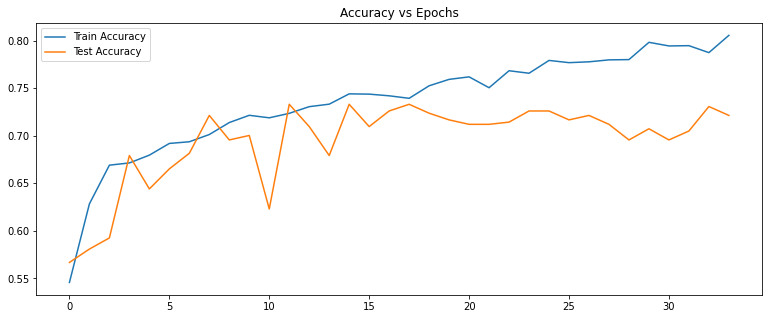

In [13]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [14]:
  y_pred = model.predict(test_images)
  predicted_classes=[]
  for i in range(len(test_labels)):
      predicted_classes.append(np.argmax(y_pred[i]))

14/14 [==============================] - 2s 63ms/step


In [15]:
accuracy_score(test_labels, predicted_classes)

0.7587822014051522

In [16]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_classes,digits=4))

              precision    recall  f1-score   support

           0     0.7331    0.8364    0.7813       220
           1     0.7955    0.6763    0.7311       207

    accuracy                         0.7588       427
   macro avg     0.7643    0.7563    0.7562       427
weighted avg     0.7633    0.7588    0.7570       427



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_classes,digits=4))

              precision    recall  f1-score   support

           0     0.7647    0.7682    0.7664       220
           1     0.7524    0.7488    0.7506       207

    accuracy                         0.7588       427
   macro avg     0.7586    0.7585    0.7585       427
weighted avg     0.7588    0.7588    0.7588       427



In [17]:
checkpoint_filepath = "/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[3] Model/CNN + LSTM/"

In [18]:
model.save(str(checkpoint_filepath+ "CNN_LSTM.h5"))


In [19]:
new_model = tf.keras.models.load_model(str(checkpoint_filepath+ "CNN_LSTM.h5"))

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 10, 60, 60, 3)    12        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 58, 58, 16)    11008     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 29, 29, 16)   0         
 3D)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 29, 29, 16)   0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 27, 27, 16)    18496     
                                                      

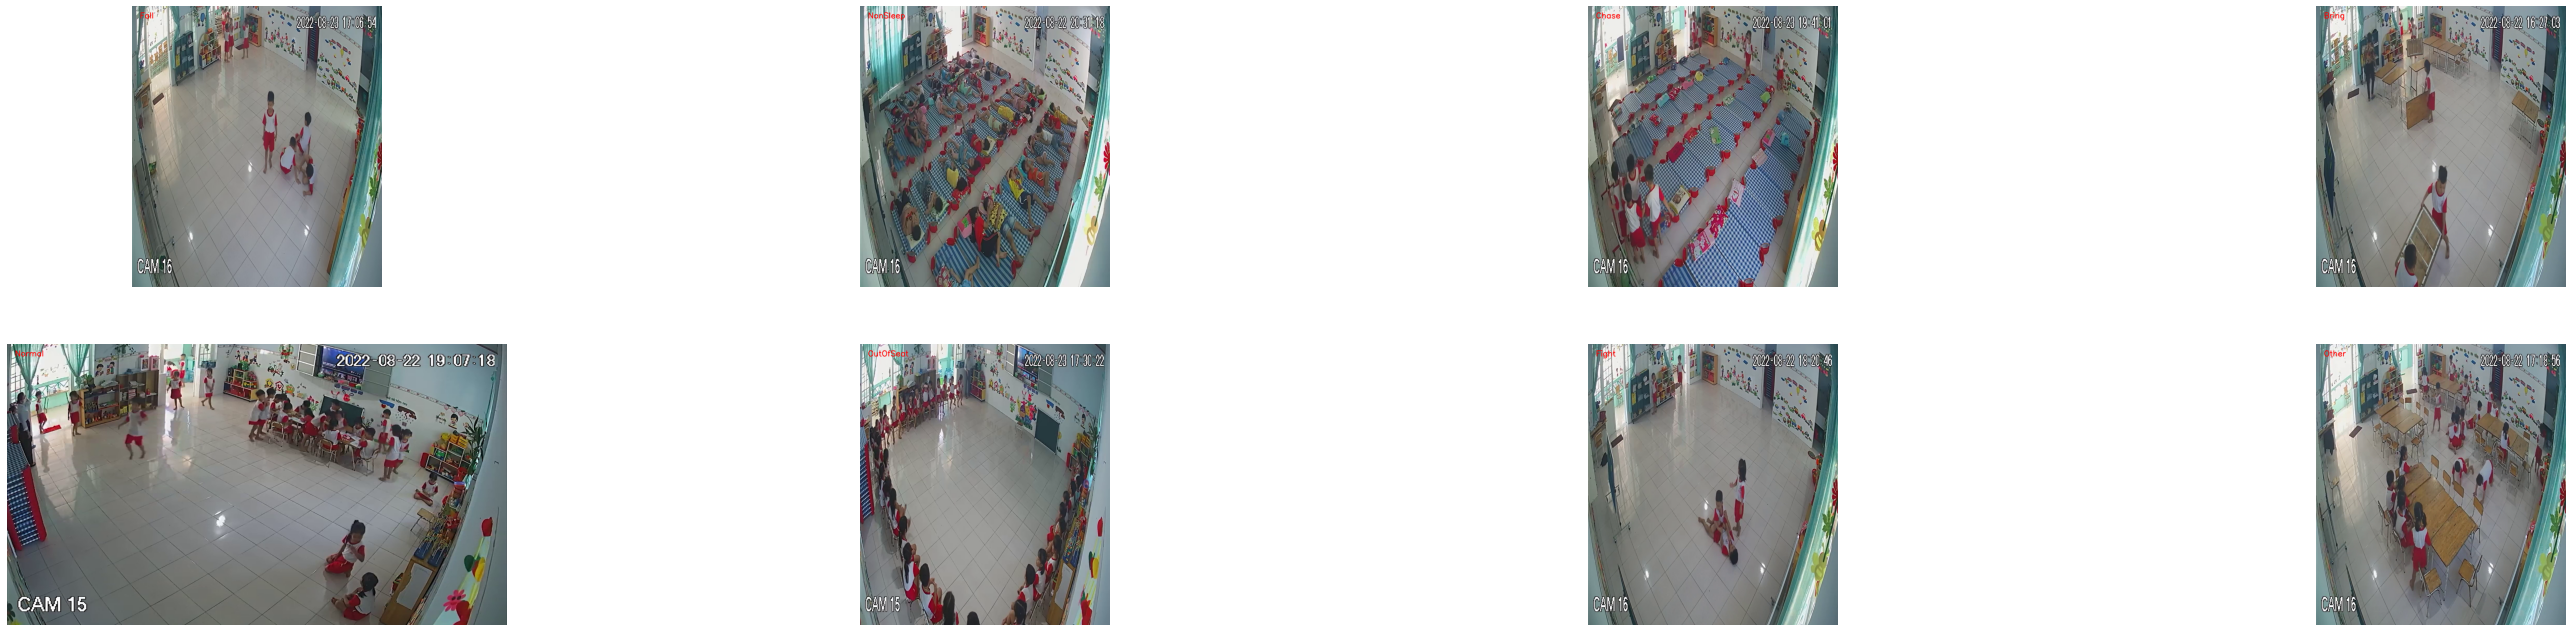

In [ ]:
import random

# Create a Matplotlib figure
plt.figure(figsize = (50, 30))
 
# Get Names of all classes in UCF101
all_classes_names = label_data.labels.values
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 8)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'/content/content/BiPS/test/{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'/content/content/BiPS/test/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
y_pred = new_model.predict(test_images)
predicted_classes=[]
for i in range(len(test_labels)):
    predicted_classes.append(np.argmax(y_pred[i]))

12/12 [==============================] - 9s 77ms/step


In [41]:
#Function for loading video files, Process and store in a data set
def load_video_name(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    video_name = []
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            temp = video_path.split("/")
            video_name.append(temp[-1])
            #Extract the frames of the current video
            #frames_list = feature_extraction(video_path)
            #images.append(frames_list)
            labels.append(label_index)
            print(label_index)
        label_index+=1
    return video_name, labels

In [ ]:
video_name, label_1 = load_video_name(test_path)

In [49]:
video_name[152:152+14]

14

In [ ]:
label_1[0:220]

In [61]:
df = pd.DataFrame({"Actual" : label_1[0:220], "predict" : predicted_classes[0:220], "video name" : video_name[0:220]})

In [64]:
df.head(30)

,Actual,predict,video name
0,0,0,video_2521.mp4
1,0,0,video_3569.mp4
2,0,1,video_4889.mp4
3,0,0,video_2795.mp4
4,0,0,video_0991.mp4
5,0,0,video_0866.mp4
6,0,1,video_1633.mp4
7,0,1,video_2164.mp4
8,0,0,video_4239.mp4
9,0,0,video_3503.mp4


Text(0, 0.5, 'True label')

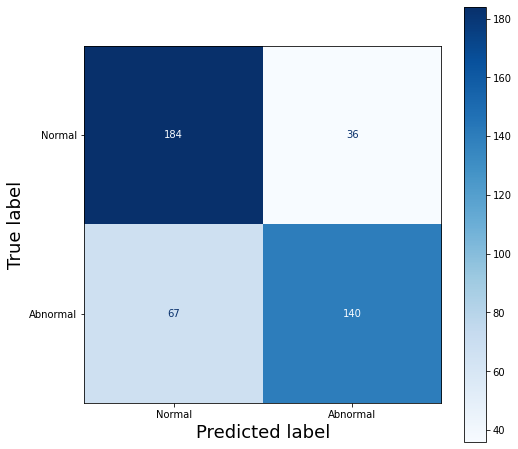

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_data["labels"])
fig, ax = plt.subplots(1, 1, figsize=(8,8))
# font = {
#     'size'   : 20}
# plt.rc('font', **font)

disp.plot(cmap=plt.cm.Blues,ax=ax)

plt.xlabel("Predicted label", fontsize=18)
plt.ylabel("True label", fontsize=18)
